In [1]:
# Imports
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
import scipy.linalg.blas as blas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# This function reads the corpus, returns a list of documents, and a list
# of their corresponding polarity labels. 
def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y

    
# Read all the documents.
X, Y = read_data('data/all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                random_state=0)

# Exercise question

In [3]:

X1 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y1 = ['rain', 'rain', 'sun', 'rain']

X2 = [{'city':'Sydney', 'month':'July'},
      {'city':'Sydney', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y2 = ['rain', 'sun', 'sun', 'rain']

classifier1 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print("First example: {}".format(accuracy_score(Y1, guesses1)))

classifier2 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
#classifier2 = make_pipeline(DictVectorizer(), LinearSVC())
classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print("Second example: {}".format(accuracy_score(Y2, guesses2)))


# Construct new example 
X3 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y3 = ['rain', 'sun', 'sun', 'rain']

classifier3 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
#classifier2 = make_pipeline(DictVectorizer(), LinearSVC())
classifier3.fit(X3, Y3)
guesses3 = classifier3.predict(X3)
print("Third example: {} ".format(accuracy_score(Y3, guesses3)))

First example: 1.0
Second example: 0.5
Third example: 0.5 


As can be seen from example 3, the problem is not with the inputs in X, but the Y values. Our hypothesis is that we have a case of linear inseperability in the second example, which makes it impossible to attain a accuracy of 1. In the below cell we will explore this hypothesis.

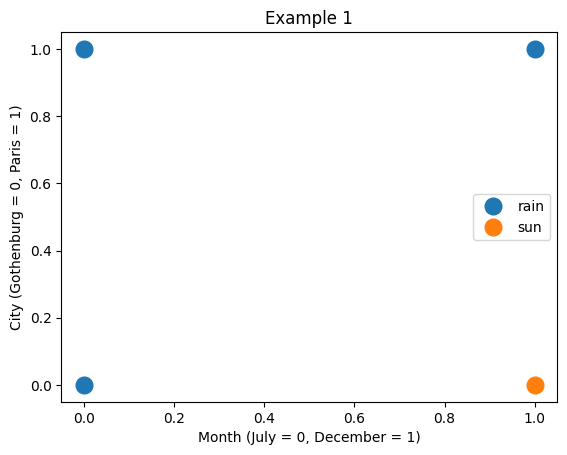

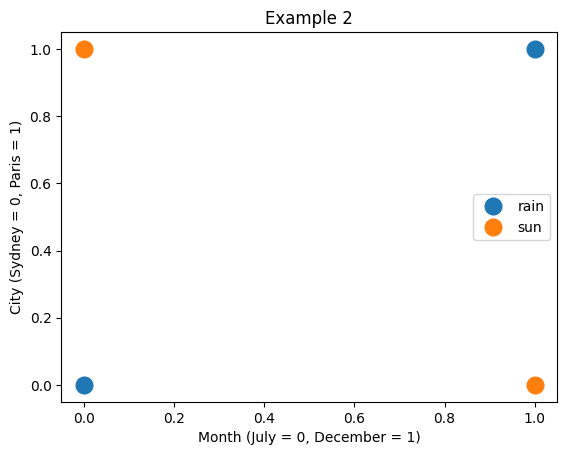

In [4]:
# Visualize difference in linear inseperability/seperability in the two examples. 

# Example 1
# Represent Gothenburg = 0, Paris = 1 and July = 0, December = 1
# Create a vectors of X2 using the representations:
rep_cities = [0,0,1,1]
rep_months = [0,1,0,1]

df_1 = pd.DataFrame({'x': rep_cities,
                   'y': rep_months,
                   'z': Y1})

groups = df_1.groupby('z')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

plt.xlabel("Month (July = 0, December = 1)")
plt.ylabel("City (Gothenburg = 0, Paris = 1)")
plt.title("Example 1")
plt.legend()
plt.show()

# Example 2
# Represent Sydney = 0, Paris = 1 and July = 0, December = 1
# Create a vectors of X2 using the representations:
rep_cities = [0,0,1,1]
rep_months = [0,1,0,1]

df_2 = pd.DataFrame({'x': rep_cities,
                   'y': rep_months,
                   'z': Y2})

groups = df_2.groupby('z')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

plt.xlabel("Month (July = 0, December = 1)")
plt.ylabel("City (Sydney = 0, Paris = 1)")
plt.title("Example 2")
plt.legend()
plt.show()

As can be seen in the plots, we have linear seperability in the first plot (Example 1) but not in the second (Example 2). This means that no linear classifier can achieve a accuracy of 1 in the second example as there is no line that perfectly separates the "rain" data points from the "sun" data points. Hence, we get an accuracy of 0.5 in the second example even though we run it on the same data set. The classifier learns a line not the individual placements of data points. 

# Task

## LinearClassifier Super Class

In [5]:
# Class taken from the provided code examples

class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])


The below implementations of SVC and Logistic Regression uses the skeleton from the Perceptron-class given in the assignment.

## Implement the SVC

In [6]:
class Pegasos_SVC(LinearClassifier):

    def __init__(self, n_iter=100000):
        self.n_iter = n_iter

    def fit(self, X, Y):

        self.lam = 1/X.shape[0]

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize weight vector w
        self.w = np.zeros(X.shape[1])

        # Pegasos algorithm for SVC
        for t in range(1, self.n_iter+1): # Repeat
            random_idx = np.random.randint(X.shape[0])
            
            x = X[random_idx]

            y = Ye[random_idx]

            eta = 1/(self.lam*t)
            score = self.decision_function(x)

            if y*score < 1:
                self.w = (1 - eta*self.lam)*self.w + (eta*y)*x
            else:
                self.w = (1 - eta*self.lam)*self.w
            

## Implement Logistic Regression

In [7]:
class Pegasos_LogReg(LinearClassifier):

    def __init__(self, n_iter=100000):
        self.n_iter = n_iter

    def fit(self, X, Y):

        self.lam = 1/X.shape[0]

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize weight vector w
        self.w = np.zeros(X.shape[1])

        # Pegasos algorithm for logistic regression
        for t in range(1, self.n_iter+1): # Repeat
            random_idx = np.random.randint(X.shape[0])
            
            x = X[random_idx]

            y = Ye[random_idx]

            eta = 1/(self.lam*t)

            self.w = (1-eta*self.lam)*self.w + (x*eta*y)/(1+np.exp(y*self.decision_function(x)))
                
            

## Run classification function

The below code cell runs and evaluates the algorithm given in the pipeline. 

In [8]:
# Set up the preprocessing steps and the classifier.
svc_pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    
    Pegasos_SVC() 
)

logreg_pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    
    Pegasos_LogReg()
)

# Train the SVC classifier.
t0 = time.time()
svc_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('SVC training time: {:.2f} sec.'.format(t1-t0))

# Evaluate SVC on the test set.
Yguess = svc_pipeline.predict(Xtest)
print('SVC accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))


# Train the Logistic Regression classifier.
t0 = time.time()
logreg_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Logistic Regression training time: {:.2f} sec.'.format(t1-t0))

# Evaluate Logistic Regression on the test set.
Yguess = logreg_pipeline.predict(Xtest)
print('Logistic Regression accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))
    

SVC training time: 2.75 sec.
SVC accuracy: 0.8330.
Logistic Regression training time: 3.62 sec.
Logistic Regression accuracy: 0.8359.


# Bonus task #1

We choose to solve bonus task #1 - Making your code more efficient. Our solutions are implemented below and we work only with the Logistic Regression model.

## (a) Faster linear algebra operations

In [9]:
class Pegasos_LogReg_faster_linalg(LinearClassifier):

    def __init__(self, n_iter=100000):
        self.n_iter = n_iter

    def fit(self, X, Y):

        self.lam = 1/X.shape[0]

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        self.w = np.zeros(X.shape[1])

        # Pegasos algorithm for logistic regression
        for t in range(1, self.n_iter+1): # Repeat
            random_idx = np.random.randint(X.shape[0])
            
            x = X[random_idx]

            y = Ye[random_idx]

            eta = 1/(self.lam*t)

            # Store current self.w in separate variable because the unscaled version is used in the second term of the update function
            w = self.w

            # Performe scaling of w
            blas.dscal((1-eta*self.lam), self.w)
            
            # Compute the new w 
            blas.daxpy(x, self.w, a = (eta*y)/(1+np.exp(y * blas.ddot(x, w))))


## (b) Using sparse vectors

Removing the SelectKBest from the pipeline results in a much worse training time of 71 seconds and a slight decrease in accuracy. When adding the option ngram_range=(1,2) to the TFIDVectorizer we also get worse training time, around 5 seconds. However, the accuracy of the model increases. This is understandable as in both cases we run the model using more input features which will take longer to process, the linear algebra operations become larger.

In [10]:
logreg_pipeline = make_pipeline(
    TfidfVectorizer(),#ngram_range=(1,2)),
    #SelectKBest(k=1000),
    Normalizer(),
    
    Pegasos_LogReg()
)

# Train the Logistic Regression classifier.
t0 = time.time()
logreg_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Logistic Regression training time: {:.2f} sec.'.format(t1-t0))

# Evaluate Logistic Regression on the test set.
Yguess = logreg_pipeline.predict(Xtest)
print('Logistic Regression accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

KeyboardInterrupt: 

In [11]:
# Utility functions for sparse matrix operations taken from provided code examples
def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return np.dot(w[x.indices], x.data)

In [23]:
# Implements a sparse version of the Pegasos Logistic Regression model by
# using the above utility functions instead of numpy operations to carry out linear algebra
# operations. 

class Sparse_Pegasos_LogReg(LinearClassifier):

    def __init__(self, n_iter=100000):
        self.n_iter = n_iter

    def fit(self, X, Y):

        self.lam = 1/X.shape[0]

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        self.w = np.zeros(X.shape[1])

        # Pegasos algorithm for logistic regression
        for t in range(1, self.n_iter+1): # Repeat
            random_idx = np.random.randint(X.shape[0])
            
            x = X[random_idx]

            y = Ye[random_idx]

            eta = 1/(self.lam*t)

            factor = (eta*y)/(1+np.exp(y*sparse_dense_dot(x,self.w)))

            # Scale self.w
            blas.dscal((1-eta*self.lam), self.w)

            # Update self.w
            add_sparse_to_dense(x, self.w, factor)
                
            

## (c) Speeding up the scaling operation

In [50]:
# Extending the solution in (b) with sped up scaling of the weight vector

class Sparse_and_sped_up_scaling_Pegasos_LogReg(LinearClassifier):

    def __init__(self, n_iter=100000):
        self.n_iter = n_iter

    def fit(self, X, Y):

        self.lam = 1/X.shape[0]

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        self.w = np.zeros(X.shape[1])

        # Intitialize scaling vector
        a = 1

        # Pegasos algorithm for logistic regression
        for t in range(1, self.n_iter+1): # Repeat

            random_idx = np.random.randint(X.shape[0])
            
            x = X[random_idx]

            y = Ye[random_idx]

            eta = 1/(self.lam*t)

            # a added to change the dot product between the weight vector and the feature vector as described in a4_clarification.pdf
            factor = (eta*y)/((1+np.exp(y*a*sparse_dense_dot(x,self.w))))

            # Scale scaling factor
            if t != 1: # When t = 1, (1-eta*self.lam) becomes 0
                a = a*(1-eta*self.lam)

            # “compensate” for the fact that w eventually will be scaled by a
            factor = factor / a

            # Update self.w
            add_sparse_to_dense(x, self.w, factor)
        
        # Scale w with the postponed scaling
        self.w *= a
                
            

## Test new models against the original

In [51]:
# Compare to baseline Logistic Regression
def eval_comparison(classifier,name_of_classifier):
    
    # Read all the documents.
    X, Y = read_data('data/all_sentiment_shuffled.txt')

    # Split into training and test parts.
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)

    orig_logreg_pipeline = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=1000),
        Normalizer(),
        
        Pegasos_LogReg()
    )

    new_pipeline = make_pipeline(
        TfidfVectorizer(),
        #SelectKBest(k=1000),
        Normalizer(),
        
        classifier
    )

    # Train the original Logistic Regression classifier.
    t0 = time.time()
    orig_logreg_pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    orig_time = t1-t0
    print('Original Logistic Regression training time: {:.2f} sec.'.format(orig_time))

    # Evaluate SVC on the test set.
    Yguess = orig_logreg_pipeline.predict(Xtest)
    print('Original Logistic Regression accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

    orig_results_dict = {
        'version': 'Original  Pegasos_LogReg',
        'accuracy': accuracy_score(Ytest, Yguess),
        'time': t1-t0,
        'diff' : 0
    }

    # Train the new Logistic Regression classifier.
    t0 = time.time()
    new_pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    new_time = t1-t0
    print('{} training time: {:.2f} sec.'.format(name_of_classifier, new_time))

    # Evaluate new Logistic Regression on the test set.
    Yguess = new_pipeline.predict(Xtest)
    print('{} accuracy: {:.4f}.'.format(name_of_classifier, accuracy_score(Ytest, Yguess)))
    
    time_diff = orig_results_dict['time']-new_time
    new_results_dict = {
        'version': str(name_of_classifier),
        'accuracy': accuracy_score(Ytest, Yguess),
        'time': t1-t0,
        'diff' : time_diff
    }

    # Print time difference between models
    print("{} is {} seconds faster than the original \n".format(name_of_classifier, orig_time - new_time))

    print("------------------")

#eval_comparison(Pegasos_LogReg_faster_linalg(), "Faster linalg LogReg")
#eval_comparison(Sparse_Pegasos_LogReg(), "Sparse LogReg")
eval_comparison(Sparse_and_sped_up_scaling_Pegasos_LogReg(), "Sparse and sped up scaling LogReg")

Original Logistic Regression training time: 4.74 sec.
Original Logistic Regression accuracy: 0.8309.
Sparse and sped up scaling LogReg training time: 19.46 sec.
Sparse and sped up scaling LogReg accuracy: 0.8326.
Sparse and sped up scaling LogReg is -14.71980595588684 seconds faster than the original 

------------------


In [31]:
#Create a panda to present the result in a  neat way
results_list = []

#Runt tests
dict1, dict2 = eval_comparison(Pegasos_LogReg_faster_linalg(), "Faster linalg LogReg")
dict0, dict3 = eval_comparison(Sparse_Pegasos_LogReg(), "Sparse LogReg")
dict00, dict4 =eval_comparison(Sparse_and_sped_up_scaling_Pegasos_LogReg(), "Sparse and sped up scaling LogReg")
results_list.append(dict1)
results_list.append(dict2)
results_list.append(dict3)
results_list.append(dict4)

# Creating a pandas DataFrame
df = pd.DataFrame(results_list)
#df = pd.DataFrame(dict1, dict2, dict3, dict4) # try to eliminate the appends

# Printing the resulting table
print(df)


Original Logistic Regression training time: 5.26 sec.
Original Logistic Regression accuracy: 0.8355.
Faster linalg LogReg training time: 3.75 sec.
Faster linalg LogReg accuracy: 0.8355.
Faster linalg LogReg is 1.5187454223632812 seconds faster than the original 

------------------


TypeError: cannot unpack non-iterable NoneType object

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=91294706-5412-4c53-b64a-ecb74941a413' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>